In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
!pip install cptac==1.1.0

In [ ]:
import cptac

# Data Collection and Cleaning

In [ ]:
#lung adenocarcinoma
cptac.download('luad')
lu = cptac.Luad()

#Breast Invasive Carcinoma
cptac.download('brca')
br = cptac.Brca()

#Head and neck squamous cell carcinoma
cptac.download('hnscc')
hn = cptac.Hnscc()

#Glioblastoma
cptac.download('gbm')
gbm = cptac.Gbm()

#Ovarian
cptac.download('ovarian')
ov = cptac.Ovarian()

#renal cell
cptac.download('ccrcc')
cc = cptac.Ccrcc()

#Endometrial
cptac.download("endometrial")
en = cptac.Endometrial()

cptac warning: Your version of cptac (1.1.0) is out-of-date. Latest is 1.5.14. Please run 'pip install --upgrade cptac' to update it. (/usr/lib/python3.10/threading.py, line 953)


In [ ]:
lu_transcriptome = lu.get_transcriptomics()
lu_proteome = lu.get_proteomics()

hn_transcriptome = hn.get_transcriptomics()
hn_proteome = hn.get_proteomics()

gbm_transcriptome = gbm.get_transcriptomics()
gbm_proteome = gbm.get_proteomics()

br_transcriptome = br.get_transcriptomics()
br_proteome = br.get_proteomics()

ov_transcriptome = ov.get_transcriptomics()
ov_proteome = ov.get_proteomics()

cc_transcriptome = cc.get_transcriptomics()
cc_proteome = cc.get_proteomics()

en_transcriptome = en.get_transcriptomics()
en_proteome = en.get_proteomics()

In [ ]:
lu_combined = pd.concat([lu_transcriptome, lu_proteome], axis=1)
hn_combined = pd.concat([hn_transcriptome, hn_proteome], axis=1)
gbm_combined = pd.concat([gbm_transcriptome, gbm_proteome], axis=1)
br_combined = pd.concat([br_transcriptome, br_proteome], axis=1)
ov_combined = pd.concat([ov_transcriptome, ov_proteome], axis=1)
cc_combined = pd.concat([cc_transcriptome, cc_proteome], axis=1)
en_combined = pd.concat([en_transcriptome, en_proteome], axis=1)

In [ ]:
print(lu_combined.columns.duplicated().any())
print(hn_combined.columns.duplicated().any())
print(gbm_combined.columns.duplicated().any())
print(br_combined.columns.duplicated().any())
print(ov_combined.columns.duplicated().any())
print(cc_combined.columns.duplicated().any())
print(en_combined.columns.duplicated().any())

False
True
False
False
False
False
True


In [ ]:
hn_combined = hn_combined.loc[:, ~hn_combined.columns.duplicated()]
en_combined = en_combined.loc[:, ~en_combined.columns.duplicated()]

In [ ]:
lu_combined = lu_combined.add_prefix('Lung_')
hn_combined = hn_combined.add_prefix('HeadNeck_')
gbm_combined = gbm_combined.add_prefix('Brain_')
br_combined = br_combined.add_prefix('Breast_')
ov_combined = ov_combined.add_prefix('Ovarian_')
cc_combined = cc_combined.add_prefix('Renal_')
en_combined = en_combined.add_prefix('Endometrial_')

In [ ]:
cancer_labels = ['Lung', 'Breast', 'Head and Neck', 'Brain', 'Ovarian', 'Renal Cell', 'Endometrial']
lu_combined['Cancer'] = cancer_labels[0]
hn_combined['Cancer'] = cancer_labels[2]
gbm_combined['Cancer'] = cancer_labels[3]
br_combined['Cancer'] = cancer_labels[1]
ov_combined['Cancer'] = cancer_labels[4]
cc_combined['Cancer'] = cancer_labels[5]
en_combined['Cancer'] = cancer_labels[6]

In [ ]:
all_data = pd.concat([lu_combined, hn_combined, gbm_combined, br_combined,
                          ov_combined, cc_combined, en_combined], axis=0)

In [ ]:
missing_values = all_data.isnull().sum()
print(missing_values[missing_values > 0])

Lung_A1BG               880
Lung_A1CF               880
Lung_A2M                880
Lung_A2ML1              880
Lung_A3GALT2            888
                       ... 
Endometrial_MT-ND3     1067
Endometrial_MT-ND4      947
Endometrial_MT-ND4L    1069
Endometrial_MT-ND5      947
Endometrial_MT-ND6      998
Length: 263882, dtype: int64


In [ ]:
all_data_cleaned = all_data.fillna(0)

In [ ]:
all_data_cleaned.head()

,Lung_A1BG,Lung_A1CF,Lung_A2M,Lung_A2ML1,Lung_A3GALT2,Lung_A4GALT,Lung_A4GNT,Lung_AAAS,Lung_AACS,Lung_AADAC,...,Endometrial_MT-CO2,Endometrial_MT-CO3,Endometrial_MT-CYB,Endometrial_MT-ND1,Endometrial_MT-ND2,Endometrial_MT-ND3,Endometrial_MT-ND4,Endometrial_MT-ND4L,Endometrial_MT-ND5,Endometrial_MT-ND6
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00001,2.2545,-2.7845,8.0488,-3.6051,-1.3305,0.8208,-1.0519,3.4780,2.6953,-3.3578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C3L-00009,1.4770,-1.9278,8.9855,0.4851,-2.4401,1.7417,-1.5157,4.1043,2.8091,0.0472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C3L-00080,1.5103,-4.9913,7.4303,-4.3766,-2.1868,-0.3121,-2.3936,4.6577,3.0394,1.2233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C3L-00083,3.0398,-3.5440,9.4109,-3.1840,-3.2313,4.3862,-3.0231,3.9942,3.4665,-1.7667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C3L-00093,1.7528,-5.2883,9.1136,-2.9449,-1.9313,1.5985,-3.3751,3.8190,3.1688,-2.3956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = all_data_cleaned.drop('Cancer', axis=1)
y = all_data_cleaned['Cancer']


selected_columns = random.sample(list(X.columns), 4000)
X_sample = X[selected_columns]

X_train, X_val, y_train, y_val = train_test_split(X_sample, y, test_size=0.2, random_state=42)


In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_val.shape)

# Check class balance in the target variable
print("y_train distribution:")
print(y_train.value_counts())

print("y_test distribution:")
print(y_val.value_counts())

X_train shape: (872, 4000)
X_test shape: (219, 4000)
y_train shape: (872,)
y_test shape: (219,)
y_train distribution:
Cancer
Lung             166
Renal Cell       161
Head and Neck    144
Endometrial      120
Ovarian          102
Breast            94
Brain             85
Name: count, dtype: int64
y_test distribution:
Cancer
Head and Neck    45
Lung             45
Renal Cell       33
Breast           28
Endometrial      24
Brain            24
Ovarian          20
Name: count, dtype: int64


# Define Tokens and Dataset

In [ ]:
def tokenize(gene_data, protein_data, embedding_dim, batch_size = 32):

    gene_array = gene_data.to_numpy()
    protein_array = protein_data.to_numpy()

    print('step 1')


    gene_tensor = torch.tensor(gene_array, dtype=torch.float32)
    protein_tensor = torch.tensor(protein_array, dtype=torch.float32)

    print('hello')

    num_samples, num_genes = gene_tensor.shape
    num_samples, num_proteins = protein_tensor.shape

    print(num_samples, num_genes, num_proteins)

    gene_embedding = nn.Embedding(num_genes, embedding_dim)
    protein_embedding = nn.Embedding(num_proteins, embedding_dim)
    value_encoder = nn.Linear(1, embedding_dim)

    gene_tokens_list = []
    protein_tokens_list = []

    for start in range(0, num_samples, batch_size):
        print(start)
        end = min(start + batch_size, num_samples)
        gene_batch = gene_data.iloc[start:end].to_numpy()
        protein_batch = protein_data.iloc[start:end].to_numpy()

        gene_tensor = torch.tensor(gene_batch, dtype=torch.float32)
        protein_tensor = torch.tensor(protein_batch, dtype=torch.float32)

        batch_size_actual = gene_tensor.size(0)

        gene_ids = torch.arange(num_genes).unsqueeze(0).repeat(batch_size_actual, 1).long()
        protein_ids = torch.arange(num_proteins).unsqueeze(0).repeat(batch_size_actual, 1).long()

        gene_id_embeddings = gene_embedding(gene_ids)
        protein_id_embeddings = protein_embedding(protein_ids)

        gene_values = gene_tensor.unsqueeze(-1)
        protein_values = protein_tensor.unsqueeze(-1)

        gene_value_embeddings = value_encoder(gene_values)
        protein_value_embeddings = value_encoder(protein_values)

        print('tokenizing')

        gene_tokens = gene_id_embeddings + gene_value_embeddings
        protein_tokens = protein_id_embeddings + protein_value_embeddings

        # Yield this batch of tokens instead of storing them
        yield gene_tokens, protein_tokens

In [ ]:
class omics_dataset(Dataset):
    def __init__(self, gene_data, protein_data, labels, gene_embedding, protein_embedding, value_encoder):
        self.gene_data = gene_data
        self.protein_data = protein_data
        self.labels = labels
        self.gene_embedding = gene_embedding
        self.protein_embedding = protein_embedding
        self.value_encoder = value_encoder
        self.num_genes = gene_data.shape[1]
        self.num_proteins = protein_data.shape[1]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        gene_row = self.gene_data[idx]
        protein_row = self.protein_data[idx] # shape (1, num_proteins)

        gene_tensor = torch.tensor(gene_row, dtype=torch.float32)     # (1, num_genes)
        protein_tensor = torch.tensor(protein_row, dtype=torch.float32)# (1, num_proteins)

        gene_ids = torch.arange(self.num_genes).unsqueeze(0).long()      # (1, num_genes)
        protein_ids = torch.arange(self.num_proteins).unsqueeze(0).long()# (1, num_proteins)

        gene_id_embeddings = self.gene_embedding(gene_ids)
        protein_id_embeddings = self.protein_embedding(protein_ids)

        gene_values = gene_tensor.unsqueeze(-1)    # (1, num_genes, 1)
        protein_values = protein_tensor.unsqueeze(-1) # (1, num_proteins, 1)

        gene_value_embeddings = self.value_encoder(gene_values)
        protein_value_embeddings = self.value_encoder(protein_values)

        gene_tokens = gene_id_embeddings + gene_value_embeddings   # (1, num_genes, embedding_dim)
        protein_tokens = protein_id_embeddings + protein_value_embeddings # (1, num_proteins, embedding_dim)

        # Squeeze out the batch dimension since we return a single sample
        gene_tokens = gene_tokens.squeeze(0)
        protein_tokens = protein_tokens.squeeze(0)

        return gene_tokens, protein_tokens, self.labels[idx]

# Architecture Development

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

NameError: name 'X_train' is not defined

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values)
y_val_encoded = label_encoder.transform(y_val.values)

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long).to(device)

In [ ]:
class cross_attention_layer(nn.Module):
    def __init__(self, embedding_dim, nhead = 8, dropout = 0.1):
        super(cross_attention_layer, self).__init__()
        self.gene_to_protein = nn.MultiheadAttention(embedding_dim, nhead, dropout=dropout)
        self.protein_to_gene = nn.MultiheadAttention(embedding_dim, nhead, dropout=dropout)

        self.norm_gene = nn.LayerNorm(embedding_dim)
        self.norm_protein = nn.LayerNorm(embedding_dim)

        self.ff_gene = nn.Sequential(
            nn.Linear(embedding_dim, 4*embedding_dim),
            nn.ReLU(),
            nn.Linear(4*embedding_dim, embedding_dim)
        )
        self.ff_protein = nn.Sequential(
            nn.Linear(embedding_dim, 4*embedding_dim),
            nn.ReLU(),
            nn.Linear(4*embedding_dim, embedding_dim)
        )

        def forward(self, gene_tokens, protein_tokens):
            gene_updated, _ = self.gene_to_protein(gene_tokens, protein_tokens, protein_tokens)

            gene_encoded = self.norm_gene(gene_tokens + gene_updated)
            gene_encoded = self.norm_gene(gene_encoded + self.ff_gene(gene_encoded))

            protein_updated, _ = self.protein_to_gene(protein_tokens, gene_encoded, gene_encoded)

            protein_encoded = self.norm_protein(protein_tokens + protein_updated)
            protein_encoded = self.norm_protein(protein_encoded + self.ff_protein(protein_encoded))

            return gene_encoded, protein_encoded



In [ ]:
class omics_transformer(nn.Module):
    def __init__(self, embedding_dim, num_cancers, nhead = 8, num_layers = 10, dim_feedforward = 256, dropout = 0.1):
        super(omics_transformer, self).__init__()
        self.embedding_dim = embedding_dim

        gene_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                        nhead=nhead,
                                                        dim_feedforward=dim_feedforward,
                                                        dropout=dropout)

        self.gene_encoder = nn.TransformerEncoder(gene_encoder_layer, num_layers=num_layers)

        protein_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                            nhead=nhead,
                                                            dim_feedforward=dim_feedforward,
                                                            dropout=dropout)

        self.protein_encoder = nn.TransformerEncoder(protein_encoder_layer, num_layers=num_layers)
        self.cross_attention = cross_attention_layer(embedding_dim, nhead, dropout)

        self.combine = nn.Linear(2*embedding_dim, embedding_dim)

        self.final = nn.Linear(embedding_dim, num_cancers)

    def forward(self, gene_tokens, protein_tokens):
        gene_tokens = gene_tokens.permute(1,0,2)
        protein_tokens = protein_tokens.permute(1,0,2)

        gene_encoded = self.gene_encoder(gene_tokens)
        protein_encoded = self.protein_encoder(protein_tokens)

        gene_cross, protein_cross = self.cross_attention(gene_encoded, protein_encoded)

        gene_pooled = torch.mean(gene_cross, dim=1)
        protein_pooled = torch.mean(protein_cross, dim=1)

        combined = torch.cat([gene_pooled, protein_pooled], dim = 1)
        combined = self.combine(combined)

        logits = self.final(combined)

        return logits



# Training

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
        model.train()
        train_loss = 0.0
        for gene_tokens, protein_tokens, labels in train_loader:

            print('\nTraining')
            optimizer.zero_grad()

            gene_tokens = gene_tokens.to(device)
            protein_tokens = protein_tokens.to(device)
            labels = labels.to(device)

            outputs = model(gene_tokens, protein_tokens)
            loss_value = loss(outputs, labels)

            loss_value.backward()
            optimizer.step()

            train_loss += loss_value.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for gene_tokens, protein_tokens, labels in val_loader:

                gene_tokens = gene_tokens.to(device)
                protein_tokens = protein_tokens.to(device)
                labels = labels.to(device)

                outputs = model(gene_tokens, protein_tokens)
                loss_value = loss(outputs, labels)
                val_loss += loss_value.item()

            val_loss /= len(val_loader)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [ ]:
cancer_labels = ['Lung', 'Breast', 'Head and Neck', 'Brain', 'Ovarian', 'Renal Cell', 'Endometrial']
label_to_id = {label: idx for idx, label in enumerate(cancer_labels)}


lu_transcriptome['Cancer'] = cancer_labels[0]
br_transcriptome['Cancer'] = cancer_labels[1]
hn_transcriptome['Cancer'] = cancer_labels[2]
gbm_transcriptome['Cancer'] = cancer_labels[3]
ov_transcriptome['Cancer'] = cancer_labels[4]
cc_transcriptome['Cancer'] = cancer_labels[5]
en_transcriptome['Cancer'] = cancer_labels[6]

lu_proteome['Cancer'] = cancer_labels[0]
br_proteome['Cancer'] = cancer_labels[1]
hn_proteome['Cancer'] = cancer_labels[2]
gbm_proteome['Cancer'] = cancer_labels[3]
ov_proteome['Cancer'] = cancer_labels[4]
cc_proteome['Cancer'] = cancer_labels[5]
en_proteome['Cancer'] = cancer_labels[6]

all_transcriptome_data = pd.concat([lu_transcriptome, br_transcriptome, hn_transcriptome, gbm_transcriptome,
                                    ov_transcriptome, cc_transcriptome, en_transcriptome], axis = 0)
all_proteome_data = pd.concat([lu_proteome, br_proteome, hn_proteome, gbm_proteome,
                                    ov_proteome, cc_proteome, en_proteome], axis = 0)

all_transcriptome_data = all_transcriptome_data.dropna(subset=['Cancer'])
all_proteome_data = all_proteome_data.dropna(subset=['Cancer'])

all_labels = all_transcriptome_data['Cancer'].values

numeric_labels = [label_to_id[label] for label in all_labels]
labels_tensor = torch.tensor(numeric_labels, dtype=torch.long).to(device)

In [ ]:
common_samples = all_transcriptome_data.index.intersection(all_proteome_data.index)
all_transcriptome_data = all_transcriptome_data.loc[common_samples]
all_proteome_data = all_proteome_data.loc[common_samples]

In [ ]:
all_transcriptome_data = all_transcriptome_data.fillna(0)
all_proteome_data = all_proteome_data.fillna(0)

all_transcriptome_data = all_transcriptome_data.drop('Cancer', axis = 1)
all_proteome_data = all_proteome_data.drop('Cancer', axis = 1)

gene_array = all_transcriptome_data.astype(float).to_numpy()
protein_array = all_proteome_data.astype(float).to_numpy()

print([i for i in gene_array[0] if type(i) is object])

print(gene_array.dtype)

gene_tensor = torch.tensor(gene_array, dtype=torch.float32)
protein_tensor = torch.tensor(protein_array, dtype=torch.float32)

num_samples, num_genes = gene_tensor.shape
num_samples, num_proteins = protein_tensor.shape

embedding_dim = 128

gene_embedding = nn.Embedding(num_genes, embedding_dim)
protein_embedding = nn.Embedding(num_proteins, embedding_dim)
value_encoder = nn.Linear(1, embedding_dim)

#gene_tokens, protein_tokens = tokenize(all_transcriptome_data.drop('Cancer', axis = 1),
                                      # all_proteome_data.drop('Cancer', axis = 1), 128)

[]
float64


In [ ]:
print(gene_array)

[[6.2 4.46 13.49 ... 0.0 0.0 0.0]
 [5.44 3.46 13.6 ... 0.0 0.0 0.0]
 [5.14 3.4 14.44 ... 0.0 0.0 0.0]
 ...
 [7.36 2.99 15.17 ... 9.87 9.62 4.44]
 [6.8 2.72 16.02 ... 9.64 9.11 5.32]
 [7.61 2.4 16.07 ... 10.33 8.99 4.85]]


In [ ]:
all_transcriptome_data = all_transcriptome_data.fillna(0)
all_proteome_data = all_proteome_data.fillna(0)

gene_array = all_transcriptome_data.drop('Cancer', axis = 1).to_numpy()
protein_array = all_proteome_data.drop('Cancer', axis = 1).to_numpy()

KeyError: "['Cancer'] not found in axis"

In [ ]:
print(gene_array.shape)
print(protein_array.shape)

(260, 100891)
(260, 45237)


In [ ]:
# #num_samples = gene_tokens.size(0)

train_indices, val_indices = train_test_split(list(range(num_samples)), test_size=0.3, random_state=42)
train_gene_data = gene_array[train_indices]
train_protein_data = protein_array[train_indices]
train_labels = labels_tensor[train_indices]

val_gene_data = gene_array[val_indices]
val_protein_data = protein_array[val_indices]
val_labels = labels_tensor[val_indices]

# train_gene_tokens = gene_tokens[train_indices]
# train_protein_tokens = protein_tokens[train_indices]
# train_labels = labels_tensor[train_indices]

# val_gene_tokens = gene_tokens[val_indices]
# val_protein_tokens = protein_tokens[val_indices]
# val_labels = labels_tensor[val_indices]

# train_dataset = omics_dataset(train_gene_tokens, train_protein_tokens, train_labels)
# val_dataset = omics_dataset(val_gene_tokens, val_protein_tokens, val_labels)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataset = omics_dataset(train_gene_data, train_protein_data, train_labels, gene_embedding, protein_embedding, value_encoder)
val_dataset = omics_dataset(val_gene_data, val_protein_data, val_labels, gene_embedding, protein_embedding, value_encoder)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = omics_transformer(128, len(cancer_labels)).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5000

train_loss, val_loss = train_model(model, train_loader, val_loader, loss, optimizer, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Training Progress:   0%|          | 0/5000 [00:00<?, ?epoch/s]


Training


Training Progress:   0%|          | 0/5000 [03:24<?, ?epoch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.54 GiB. GPU 0 has a total capacity of 14.75 GiB of which 39.06 MiB is free. Process 56333 has 14.71 GiB memory in use. Of the allocated memory 13.51 GiB is allocated by PyTorch, and 1.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Predictions and Results

In [ ]:
def get_predictions(model, val_loader, device, label_to_id, accuracy = True):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for gene_tokens, protein_tokens, labels in val_loader:
            gene_tokens = gene_tokens.to(device)
            protein_tokens = protein_tokens.to(device)
            labels = labels.to(device)

            outputs = model(gene_tokens, protein_tokens)
            _, preds = torch.max(outputs, 1)
            predictions.append(preds.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)

    pred_labels = [label_to_id[p.item()] for p in predictions]
    true_labels = [label_to_id[t.item()] for t in true_labels]

    if accuracy:
        accuracy = (pred_labels == true_labels).sum().item() / len(true_labels)
    else:
        accuracy = None

    return pred_labels, true_labels, accuracy

In [ ]:
pred_labels, true_labels, accuracy = get_predictions(model, val_loader, device, label_to_id, accuracy = True)
print(f'Model Accuracy: {accuracy}')

In [ ]:
print(classification_report(true_labels, pred_labels, target_names=label_to_id.keys()))

# Archived Models

In [ ]:
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(autoencoder, self).__init__()
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train_autoencoder(model, train_loader, val_loader, loss, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
        model.train()
        train_loss = 0.0
        for x in train_loader:
            x = x[0].to(device)
            optimizer.zero_grad()
            reconstructed = model(x)
            loss_value = loss(reconstructed, x)
            loss_value.backward()
            optimizer.step()
            train_loss += loss_value.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x in val_loader:
                x = x[0].to(device)
                reconstructed = model(x)
                loss_value = loss(reconstructed, x)
                val_loss += loss_value.item()


        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    return train_losses, val_losses




In [ ]:
class cancer_transformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, nhead=4, num_layers=10, dim_feedforward=256, dropout=0.1):
        super(cancer_transformer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.embedding = nn.Linear(1, hidden_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, input_size, hidden_size))
        self.transformer = nn.TransformerEncoder(
                          nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout),
                          num_layers=num_layers)
        self.final = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = x.permute(1,0,2)
        x = self.transformer(x)
        x = x.mean(dim=0)
        x = self.final(x)
        return x

In [ ]:
class cancer_mlp(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(cancer_mlp, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, 3*hidden_size),
            nn.ReLU(),
            nn.Linear(3*hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
num_features = X_train_tensor.shape[1]
hidden_size = 128
num_classes = len(torch.unique(y_train_tensor))

model = cancer_transformer(num_features, hidden_size, num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tensor.cpu().numpy()), y=y_train_tensor.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


loss = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 5000
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
latent_dim = 64
auto_loss = nn.MSELoss()
autoencoder_model = autoencoder(num_features, latent_dim).to(device)
auto_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [ ]:
train_auto, val_auto = train_autoencoder(autoencoder_model, train_loader, val_loader, auto_loss, auto_optimizer, num_epochs)

Training Progress: 100%|██████████| 5000/5000 [03:30<00:00, 23.73epoch/s]


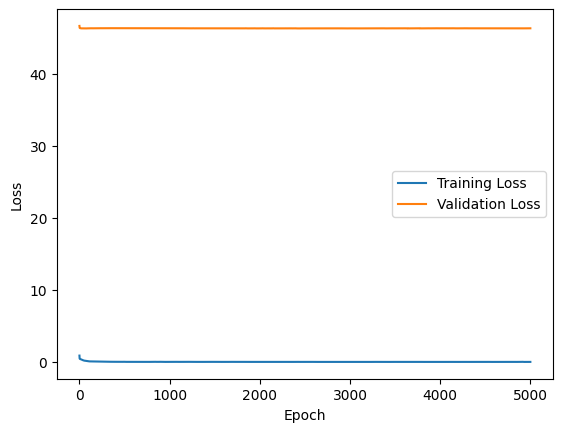

In [ ]:
plt.plot(train_auto, label='Training Loss')
plt.plot(val_auto, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
X_train_latent = autoencoder_model.encoder(X_train_tensor.to(device)).detach().cpu().numpy()
X_val_latent = autoencoder_model.encoder(X_val_tensor.to(device)).detach().cpu().numpy()

new_train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_latent, dtype=torch.float32), y_train_tensor)
new_val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val_latent, dtype=torch.float32), y_val_tensor)

new_train_loader = torch.utils.data.DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
new_val_loader = torch.utils.data.DataLoader(new_val_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(torch.unique(y_train_tensor))
model = cancer_mlp(latent_dim, hidden_size, num_classes).to(device)

NameError: name 'autoencoder_model' is not defined

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
        model.train()
        train_loss = 0.0
        x,y = next(iter(train_loader))
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss_value = loss(outputs, y)
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            x,y = next(iter(val_loader))
            x,y = x.to(device), y.to(device)
            outputs = model(x)
            loss_value = loss(outputs, y)
            val_loss += loss_value.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model(model, new_train_loader, new_val_loader, loss, optimizer, num_epochs)

Training Progress: 100%|██████████| 5000/5000 [06:25<00:00, 12.97epoch/s]


In [ ]:
def get_predictions(model, X, device):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_pred = model(X_tensor)
        probs = F.softmax(y_pred, dim=1)
        preds = torch.argmax(probs, dim=1)
    return preds.cpu().numpy()

In [ ]:
y_pred_classes = get_predictions(model, X_val_latent, device)

In [ ]:
y_true = y_val_tensor.cpu().numpy()
y_true_labels = label_encoder.inverse_transform(y_true)


In [ ]:
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_pred_labels

array(['Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Breast',
       'Breast', 'Breast', 'Breast', 'Breast', 'Breast', 'Brea

In [ ]:
print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

Accuracy: 0.1278538812785388
               precision    recall  f1-score   support

        Brain       0.00      0.00      0.00        24
       Breast       0.13      1.00      0.23        28
  Endometrial       0.00      0.00      0.00        24
Head and Neck       0.00      0.00      0.00        45
         Lung       0.00      0.00      0.00        45
      Ovarian       0.00      0.00      0.00        20
   Renal Cell       0.00      0.00      0.00        33

     accuracy                           0.13       219
    macro avg       0.02      0.14      0.03       219
 weighted avg       0.02      0.13      0.03       219



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_true_labels

array(['Renal Cell', 'Renal Cell', 'Endometrial', 'Endometrial',
       'Renal Cell', 'Head and Neck', 'Head and Neck', 'Lung',
       'Head and Neck', 'Renal Cell', 'Lung', 'Breast', 'Renal Cell',
       'Lung', 'Head and Neck', 'Breast', 'Breast', 'Lung', 'Ovarian',
       'Head and Neck', 'Head and Neck', 'Ovarian', 'Endometrial', 'Lung',
       'Renal Cell', 'Head and Neck', 'Head and Neck', 'Lung',
       'Renal Cell', 'Brain', 'Lung', 'Lung', 'Lung', 'Brain', 'Ovarian',
       'Ovarian', 'Endometrial', 'Brain', 'Renal Cell', 'Breast',
       'Breast', 'Head and Neck', 'Lung', 'Endometrial', 'Renal Cell',
       'Brain', 'Lung', 'Head and Neck', 'Lung', 'Lung', 'Breast',
       'Ovarian', 'Breast', 'Lung', 'Breast', 'Ovarian', 'Breast',
       'Head and Neck', 'Endometrial', 'Lung', 'Endometrial', 'Lung',
       'Renal Cell', 'Brain', 'Head and Neck', 'Brain', 'Breast',
       'Breast', 'Head and Neck', 'Lung', 'Brain', 'Ovarian',
       'Endometrial', 'Renal Cell', 'Renal Cell', 

In [ ]:
print("Accuracy:", accuracy_score(y_true_labels, y_pred_classes))
# print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.0


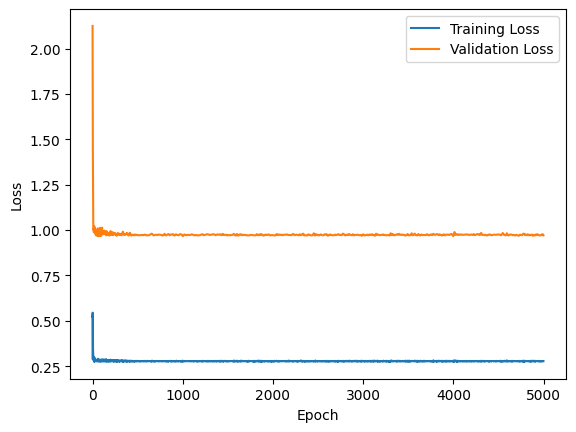

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()